In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Data Generation

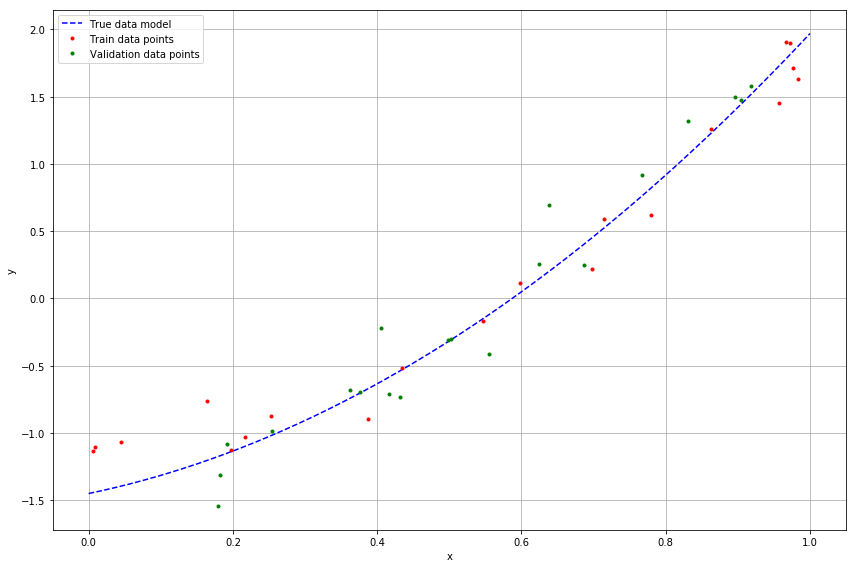

In [48]:
def poly_model(x, beta, noise_std=0):
    """
    INPUT
        x: x vector
        beta: polynomial parameters
        noise_std: enable noisy sampling (gaussian noise, zero mean, noise_std std)
    """
    pol_order = len(beta)
    x_matrix = np.array([x**i for i in range(pol_order)]).transpose()
    y = np.matmul(x_matrix, beta)
    noise = np.random.randn(len(y)) * noise_std
    return y + noise

beta_true = [-1.45, 1.12, 2.3]
noise_std = 0.2
np.random.seed(4)

### Train data
num_train_points = 20
x_train = np.random.rand(num_train_points)
y_train = poly_model(x_train, beta_true, noise_std)
with open('train_data.csv', 'w') as f:
  data = [f"{x},{y}" for x, y in zip(x_train, y_train)]
  f.write('\n'.join(data))
    
### Validation data
num_val_points = 20
x_val = np.random.rand(num_val_points)
y_val = poly_model(x_val, beta_true, noise_std)
with open('val_data.csv', 'w') as f:
  data = [f"{x},{y}" for x, y in zip(x_val, y_val)]
  f.write('\n'.join(data))

  
### Plot
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,1,1000)
plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_val, y_val, color='g', ls='', marker='.', label='Validation data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Network Definition
Define a fully connected feed-forward network with 2 hidden layers.
Use a sigmoid activation function.

In [49]:
class Net(nn.Module):
    def __init__(self,Ni,Nh1,Nh2,No):
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni,out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1,out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2,out_features=No)
        self.act = nn.Sigmoid()
        
        
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

# Dataset

In [50]:
class CsvDataset(Dataset):

  def __init__(self, csv_file, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform
    # Read the file and split the lines in a list
    with open(csv_file, 'r') as f:
      lines = f.read().split('\n')
    # Get x and y values from each line and append to self.data
    self.data = []
    for line in lines:
      sample = line.split(',')
      self.data.append((float(sample[0]), float(sample[1])))
    # Now self.data contains all our dataset.
    # Each element of the list self.data is a tuple: (input, output)

  def __len__(self):
    # The length of the dataset is simply the length of the self.data list
    return len(self.data)

  def __getitem__(self, idx):
    # Our sample is the element idx of the list self.data
    sample = self.data[idx]
    if self.transform:
        sample = self.transform(sample)
    return sample

In [51]:
class ToTensor(object):
    
    def __call__(self,sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())
               

In [52]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('train_data.csv', transform=composed_transform)
val_dataset = CsvDataset('val_data.csv', transform=composed_transform)

 # Dataloader

In [53]:
train_dataloader = DataLoader(train_dataset,batch_size=4, shuffle=True,num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset),shuffle = False, num_workers=0)

# Training loop

In [54]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [55]:
# Initialize the network

torch.manual_seed(0)
Ni = 1
Nh1 = 128
Nh2 = 256
No = 1
net = Net(Ni,Nh1,Nh2,No)
net.to(device)

Network initialized


Net(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
  (act): Sigmoid()
)

# Loss function

In [56]:
# Define the loss function

loss_fn = nn.MSELoss()

In [57]:
# Define the optimizer

optimizer= optim.Adam(net.parameters(), lr = 1e-3)

In [58]:
### TRAINING LOOP
num_epochs = 3000
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
  print('#################')
  print(f'# EPOCH {epoch_num}')
  print('#################')

  ### TRAIN
  train_loss= []
  net.train() # Training mode (e.g. enable dropout)
  for sample_batched in train_dataloader:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)

    # Forward pass
    out = net(x_batch)

    # Compute loss
    loss = loss_fn(out, label_batch)

    # Backpropagation
    net.zero_grad()
    loss.backward()

    # Update the weights
    optimizer.step()

    # Save train loss for this batch
    loss_batch = loss.detach().cpu().numpy()
    train_loss.append(loss_batch)

  # Save average train loss
  train_loss = np.mean(train_loss)
  print(f"AVERAGE TRAIN LOSS: {train_loss}")
  train_loss_log.append(train_loss)

  ### VALIDATION
  val_loss= []
  net.eval() # Evaluation mode (e.g. disable dropout)
  with torch.no_grad(): # Disable gradient tracking
    for sample_batched in val_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      out = net(x_batch)

      # Compute loss
      loss = loss_fn(out, label_batch)

      # Save val loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      val_loss.append(loss_batch)

    # Save average validation loss
    val_loss = np.mean(val_loss)
    print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
    val_loss_log.append(val_loss)
    

#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 1.3229546546936035
AVERAGE VAL LOSS: 0.9183558225631714
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 1.2685414552688599
AVERAGE VAL LOSS: 1.0421854257583618
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 1.227013349533081
AVERAGE VAL LOSS: 0.9548966884613037
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 1.1579002141952515
AVERAGE VAL LOSS: 0.8720052242279053
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 1.1531364917755127
AVERAGE VAL LOSS: 0.8605117201805115
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 1.1180839538574219
AVERAGE VAL LOSS: 0.835368812084198
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 1.0820627212524414
AVERAGE VAL LOSS: 0.8511154651641846
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 1.0436269044876099
AVERAGE VAL LOSS: 0.8140255808830261
#################
# EPOCH 

AVERAGE TRAIN LOSS: 0.11325886100530624
AVERAGE VAL LOSS: 0.10142969340085983
#################
# EPOCH 79
#################
AVERAGE TRAIN LOSS: 0.1119278222322464
AVERAGE VAL LOSS: 0.16831354796886444
#################
# EPOCH 80
#################
AVERAGE TRAIN LOSS: 0.1015629768371582
AVERAGE VAL LOSS: 0.08914307504892349
#################
# EPOCH 81
#################
AVERAGE TRAIN LOSS: 0.11020038276910782
AVERAGE VAL LOSS: 0.1067371666431427
#################
# EPOCH 82
#################
AVERAGE TRAIN LOSS: 0.12396397441625595
AVERAGE VAL LOSS: 0.15823820233345032
#################
# EPOCH 83
#################
AVERAGE TRAIN LOSS: 0.12850680947303772
AVERAGE VAL LOSS: 0.08451869338750839
#################
# EPOCH 84
#################
AVERAGE TRAIN LOSS: 0.10346178710460663
AVERAGE VAL LOSS: 0.14223968982696533
#################
# EPOCH 85
#################
AVERAGE TRAIN LOSS: 0.11172886937856674
AVERAGE VAL LOSS: 0.12022440135478973
#################
# EPOCH 86
#################
AVE

AVERAGE TRAIN LOSS: 0.08154727518558502
AVERAGE VAL LOSS: 0.10962624102830887
#################
# EPOCH 157
#################
AVERAGE TRAIN LOSS: 0.07958314567804337
AVERAGE VAL LOSS: 0.09435781091451645
#################
# EPOCH 158
#################
AVERAGE TRAIN LOSS: 0.09494868665933609
AVERAGE VAL LOSS: 0.10574445873498917
#################
# EPOCH 159
#################
AVERAGE TRAIN LOSS: 0.07862690836191177
AVERAGE VAL LOSS: 0.08193957805633545
#################
# EPOCH 160
#################
AVERAGE TRAIN LOSS: 0.08505861461162567
AVERAGE VAL LOSS: 0.08905410021543503
#################
# EPOCH 161
#################
AVERAGE TRAIN LOSS: 0.09214572608470917
AVERAGE VAL LOSS: 0.14580316841602325
#################
# EPOCH 162
#################
AVERAGE TRAIN LOSS: 0.07956984639167786
AVERAGE VAL LOSS: 0.08168971538543701
#################
# EPOCH 163
#################
AVERAGE TRAIN LOSS: 0.09262970834970474
AVERAGE VAL LOSS: 0.0881970003247261
#################
# EPOCH 164
###########

AVERAGE TRAIN LOSS: 0.06499489396810532
AVERAGE VAL LOSS: 0.0998058095574379
#################
# EPOCH 238
#################
AVERAGE TRAIN LOSS: 0.06780073791742325
AVERAGE VAL LOSS: 0.09444963932037354
#################
# EPOCH 239
#################
AVERAGE TRAIN LOSS: 0.08718325942754745
AVERAGE VAL LOSS: 0.07495937496423721
#################
# EPOCH 240
#################
AVERAGE TRAIN LOSS: 0.06125209480524063
AVERAGE VAL LOSS: 0.10842479765415192
#################
# EPOCH 241
#################
AVERAGE TRAIN LOSS: 0.08614245057106018
AVERAGE VAL LOSS: 0.10588899254798889
#################
# EPOCH 242
#################
AVERAGE TRAIN LOSS: 0.09717027097940445
AVERAGE VAL LOSS: 0.07479837536811829
#################
# EPOCH 243
#################
AVERAGE TRAIN LOSS: 0.07475563138723373
AVERAGE VAL LOSS: 0.1224481388926506
#################
# EPOCH 244
#################
AVERAGE TRAIN LOSS: 0.07330755889415741
AVERAGE VAL LOSS: 0.09597146511077881
#################
# EPOCH 245
############

AVERAGE TRAIN LOSS: 0.051215529441833496
AVERAGE VAL LOSS: 0.06889063119888306
#################
# EPOCH 318
#################
AVERAGE TRAIN LOSS: 0.05376053601503372
AVERAGE VAL LOSS: 0.06982748210430145
#################
# EPOCH 319
#################
AVERAGE TRAIN LOSS: 0.05393652990460396
AVERAGE VAL LOSS: 0.09004279971122742
#################
# EPOCH 320
#################
AVERAGE TRAIN LOSS: 0.05257972329854965
AVERAGE VAL LOSS: 0.07261303812265396
#################
# EPOCH 321
#################
AVERAGE TRAIN LOSS: 0.05398209020495415
AVERAGE VAL LOSS: 0.07529683411121368
#################
# EPOCH 322
#################
AVERAGE TRAIN LOSS: 0.04937136918306351
AVERAGE VAL LOSS: 0.08427316695451736
#################
# EPOCH 323
#################
AVERAGE TRAIN LOSS: 0.051948465406894684
AVERAGE VAL LOSS: 0.08400484919548035
#################
# EPOCH 324
#################
AVERAGE TRAIN LOSS: 0.05135316774249077
AVERAGE VAL LOSS: 0.06935809552669525
#################
# EPOCH 325
########

AVERAGE TRAIN LOSS: 0.04173633083701134
AVERAGE VAL LOSS: 0.07179203629493713
#################
# EPOCH 383
#################
AVERAGE TRAIN LOSS: 0.039794180542230606
AVERAGE VAL LOSS: 0.07027797400951385
#################
# EPOCH 384
#################
AVERAGE TRAIN LOSS: 0.043654270470142365
AVERAGE VAL LOSS: 0.06970775127410889
#################
# EPOCH 385
#################
AVERAGE TRAIN LOSS: 0.039355210959911346
AVERAGE VAL LOSS: 0.06637018918991089
#################
# EPOCH 386
#################
AVERAGE TRAIN LOSS: 0.041325561702251434
AVERAGE VAL LOSS: 0.06827468425035477
#################
# EPOCH 387
#################
AVERAGE TRAIN LOSS: 0.04022398591041565
AVERAGE VAL LOSS: 0.06689157336950302
#################
# EPOCH 388
#################
AVERAGE TRAIN LOSS: 0.06014912202954292
AVERAGE VAL LOSS: 0.07508145272731781
#################
# EPOCH 389
#################
AVERAGE TRAIN LOSS: 0.05221018195152283
AVERAGE VAL LOSS: 0.06874143332242966
#################
# EPOCH 390
######

#################
# EPOCH 468
#################
AVERAGE TRAIN LOSS: 0.038411907851696014
AVERAGE VAL LOSS: 0.06658083200454712
#################
# EPOCH 469
#################
AVERAGE TRAIN LOSS: 0.028745491057634354
AVERAGE VAL LOSS: 0.06620215624570847
#################
# EPOCH 470
#################
AVERAGE TRAIN LOSS: 0.03693743795156479
AVERAGE VAL LOSS: 0.06432874500751495
#################
# EPOCH 471
#################
AVERAGE TRAIN LOSS: 0.031106913462281227
AVERAGE VAL LOSS: 0.07494880259037018
#################
# EPOCH 472
#################
AVERAGE TRAIN LOSS: 0.02989438734948635
AVERAGE VAL LOSS: 0.0648062452673912
#################
# EPOCH 473
#################
AVERAGE TRAIN LOSS: 0.041747551411390305
AVERAGE VAL LOSS: 0.0703120082616806
#################
# EPOCH 474
#################
AVERAGE TRAIN LOSS: 0.03733399137854576
AVERAGE VAL LOSS: 0.07949113845825195
#################
# EPOCH 475
#################
AVERAGE TRAIN LOSS: 0.037211012095212936
AVERAGE VAL LOSS: 0.0657151

AVERAGE TRAIN LOSS: 0.02648736536502838
AVERAGE VAL LOSS: 0.06288929283618927
#################
# EPOCH 534
#################
AVERAGE TRAIN LOSS: 0.024407360702753067
AVERAGE VAL LOSS: 0.0645240768790245
#################
# EPOCH 535
#################
AVERAGE TRAIN LOSS: 0.02451474964618683
AVERAGE VAL LOSS: 0.06336452066898346
#################
# EPOCH 536
#################
AVERAGE TRAIN LOSS: 0.026180574670433998
AVERAGE VAL LOSS: 0.06521734595298767
#################
# EPOCH 537
#################
AVERAGE TRAIN LOSS: 0.030566638335585594
AVERAGE VAL LOSS: 0.0708240196108818
#################
# EPOCH 538
#################
AVERAGE TRAIN LOSS: 0.02582400105893612
AVERAGE VAL LOSS: 0.06620562821626663
#################
# EPOCH 539
#################
AVERAGE TRAIN LOSS: 0.024672556668519974
AVERAGE VAL LOSS: 0.06408556550741196
#################
# EPOCH 540
#################
AVERAGE TRAIN LOSS: 0.025336360558867455
AVERAGE VAL LOSS: 0.06532914936542511
#################
# EPOCH 541
#######

AVERAGE TRAIN LOSS: 0.024884697049856186
AVERAGE VAL LOSS: 0.07056532800197601
#################
# EPOCH 602
#################
AVERAGE TRAIN LOSS: 0.02276633121073246
AVERAGE VAL LOSS: 0.06425999104976654
#################
# EPOCH 603
#################
AVERAGE TRAIN LOSS: 0.022857021540403366
AVERAGE VAL LOSS: 0.0669880360364914
#################
# EPOCH 604
#################
AVERAGE TRAIN LOSS: 0.022230708971619606
AVERAGE VAL LOSS: 0.06488852202892303
#################
# EPOCH 605
#################
AVERAGE TRAIN LOSS: 0.02231604978442192
AVERAGE VAL LOSS: 0.06520520895719528
#################
# EPOCH 606
#################
AVERAGE TRAIN LOSS: 0.02435833029448986
AVERAGE VAL LOSS: 0.06708323210477829
#################
# EPOCH 607
#################
AVERAGE TRAIN LOSS: 0.02530081197619438
AVERAGE VAL LOSS: 0.06721443682909012
#################
# EPOCH 608
#################
AVERAGE TRAIN LOSS: 0.021609321236610413
AVERAGE VAL LOSS: 0.0637570172548294
#################
# EPOCH 609
########

AVERAGE VAL LOSS: 0.0661105364561081
#################
# EPOCH 669
#################
AVERAGE TRAIN LOSS: 0.02353351190686226
AVERAGE VAL LOSS: 0.06679757684469223
#################
# EPOCH 670
#################
AVERAGE TRAIN LOSS: 0.02016211673617363
AVERAGE VAL LOSS: 0.07055530697107315
#################
# EPOCH 671
#################
AVERAGE TRAIN LOSS: 0.022502386942505836
AVERAGE VAL LOSS: 0.06671370565891266
#################
# EPOCH 672
#################
AVERAGE TRAIN LOSS: 0.021351013332605362
AVERAGE VAL LOSS: 0.06697551161050797
#################
# EPOCH 673
#################
AVERAGE TRAIN LOSS: 0.022033125162124634
AVERAGE VAL LOSS: 0.06763415038585663
#################
# EPOCH 674
#################
AVERAGE TRAIN LOSS: 0.025991076603531837
AVERAGE VAL LOSS: 0.06626131385564804
#################
# EPOCH 675
#################
AVERAGE TRAIN LOSS: 0.029809510335326195
AVERAGE VAL LOSS: 0.07388835400342941
#################
# EPOCH 676
#################
AVERAGE TRAIN LOSS: 0.020884

AVERAGE TRAIN LOSS: 0.025463387370109558
AVERAGE VAL LOSS: 0.06330014765262604
#################
# EPOCH 743
#################
AVERAGE TRAIN LOSS: 0.02113467827439308
AVERAGE VAL LOSS: 0.07558105885982513
#################
# EPOCH 744
#################
AVERAGE TRAIN LOSS: 0.030675729736685753
AVERAGE VAL LOSS: 0.0617106556892395
#################
# EPOCH 745
#################
AVERAGE TRAIN LOSS: 0.023613356053829193
AVERAGE VAL LOSS: 0.06916559487581253
#################
# EPOCH 746
#################
AVERAGE TRAIN LOSS: 0.021381493657827377
AVERAGE VAL LOSS: 0.06305699050426483
#################
# EPOCH 747
#################
AVERAGE TRAIN LOSS: 0.02165014110505581
AVERAGE VAL LOSS: 0.06573012471199036
#################
# EPOCH 748
#################
AVERAGE TRAIN LOSS: 0.0211116224527359
AVERAGE VAL LOSS: 0.06693603098392487
#################
# EPOCH 749
#################
AVERAGE TRAIN LOSS: 0.034446537494659424
AVERAGE VAL LOSS: 0.07394491136074066
#################
# EPOCH 750
#######

AVERAGE TRAIN LOSS: 0.02094569243490696
AVERAGE VAL LOSS: 0.06485074758529663
#################
# EPOCH 809
#################
AVERAGE TRAIN LOSS: 0.02658933959901333
AVERAGE VAL LOSS: 0.06724918633699417
#################
# EPOCH 810
#################
AVERAGE TRAIN LOSS: 0.020283520221710205
AVERAGE VAL LOSS: 0.06750942766666412
#################
# EPOCH 811
#################
AVERAGE TRAIN LOSS: 0.021514084190130234
AVERAGE VAL LOSS: 0.06723611801862717
#################
# EPOCH 812
#################
AVERAGE TRAIN LOSS: 0.019169969484210014
AVERAGE VAL LOSS: 0.06426602602005005
#################
# EPOCH 813
#################
AVERAGE TRAIN LOSS: 0.021157586947083473
AVERAGE VAL LOSS: 0.06450740247964859
#################
# EPOCH 814
#################
AVERAGE TRAIN LOSS: 0.021389665082097054
AVERAGE VAL LOSS: 0.06768084317445755
#################
# EPOCH 815
#################
AVERAGE TRAIN LOSS: 0.02187764272093773
AVERAGE VAL LOSS: 0.06252480298280716
#################
# EPOCH 816
#####

AVERAGE TRAIN LOSS: 0.021223116666078568
AVERAGE VAL LOSS: 0.0625799149274826
#################
# EPOCH 879
#################
AVERAGE TRAIN LOSS: 0.019962644204497337
AVERAGE VAL LOSS: 0.06794960051774979
#################
# EPOCH 880
#################
AVERAGE TRAIN LOSS: 0.022769514471292496
AVERAGE VAL LOSS: 0.06890782713890076
#################
# EPOCH 881
#################
AVERAGE TRAIN LOSS: 0.025811899453401566
AVERAGE VAL LOSS: 0.0624462254345417
#################
# EPOCH 882
#################
AVERAGE TRAIN LOSS: 0.024304093793034554
AVERAGE VAL LOSS: 0.0694795772433281
#################
# EPOCH 883
#################
AVERAGE TRAIN LOSS: 0.021199416369199753
AVERAGE VAL LOSS: 0.06035396829247475
#################
# EPOCH 884
#################
AVERAGE TRAIN LOSS: 0.02428623102605343
AVERAGE VAL LOSS: 0.06317383050918579
#################
# EPOCH 885
#################
AVERAGE TRAIN LOSS: 0.02370699867606163
AVERAGE VAL LOSS: 0.0716075599193573
#################
# EPOCH 886
########

AVERAGE TRAIN LOSS: 0.02158709056675434
AVERAGE VAL LOSS: 0.06778433918952942
#################
# EPOCH 951
#################
AVERAGE TRAIN LOSS: 0.021690696477890015
AVERAGE VAL LOSS: 0.061803217977285385
#################
# EPOCH 952
#################
AVERAGE TRAIN LOSS: 0.02008173242211342
AVERAGE VAL LOSS: 0.06817153841257095
#################
# EPOCH 953
#################
AVERAGE TRAIN LOSS: 0.02052142471075058
AVERAGE VAL LOSS: 0.06664206832647324
#################
# EPOCH 954
#################
AVERAGE TRAIN LOSS: 0.02142595499753952
AVERAGE VAL LOSS: 0.06158452108502388
#################
# EPOCH 955
#################
AVERAGE TRAIN LOSS: 0.020351629704236984
AVERAGE VAL LOSS: 0.06802042573690414
#################
# EPOCH 956
#################
AVERAGE TRAIN LOSS: 0.022180968895554543
AVERAGE VAL LOSS: 0.06377259641885757
#################
# EPOCH 957
#################
AVERAGE TRAIN LOSS: 0.023314744234085083
AVERAGE VAL LOSS: 0.06899815052747726
#################
# EPOCH 958
#####

AVERAGE TRAIN LOSS: 0.02191152051091194
AVERAGE VAL LOSS: 0.07280997931957245
#################
# EPOCH 1023
#################
AVERAGE TRAIN LOSS: 0.03133397549390793
AVERAGE VAL LOSS: 0.06112608686089516
#################
# EPOCH 1024
#################
AVERAGE TRAIN LOSS: 0.01877434179186821
AVERAGE VAL LOSS: 0.07033094763755798
#################
# EPOCH 1025
#################
AVERAGE TRAIN LOSS: 0.02239398844540119
AVERAGE VAL LOSS: 0.0629357099533081
#################
# EPOCH 1026
#################
AVERAGE TRAIN LOSS: 0.021477114409208298
AVERAGE VAL LOSS: 0.060359179973602295
#################
# EPOCH 1027
#################
AVERAGE TRAIN LOSS: 0.02128024771809578
AVERAGE VAL LOSS: 0.07026676833629608
#################
# EPOCH 1028
#################
AVERAGE TRAIN LOSS: 0.020994361490011215
AVERAGE VAL LOSS: 0.061125993728637695
#################
# EPOCH 1029
#################
AVERAGE TRAIN LOSS: 0.02106691338121891
AVERAGE VAL LOSS: 0.06285803765058517
#################
# EPOCH 1030

AVERAGE TRAIN LOSS: 0.019617602229118347
AVERAGE VAL LOSS: 0.06205074489116669
#################
# EPOCH 1095
#################
AVERAGE TRAIN LOSS: 0.021677862852811813
AVERAGE VAL LOSS: 0.06627947092056274
#################
# EPOCH 1096
#################
AVERAGE TRAIN LOSS: 0.020685020834207535
AVERAGE VAL LOSS: 0.06564841419458389
#################
# EPOCH 1097
#################
AVERAGE TRAIN LOSS: 0.02341548725962639
AVERAGE VAL LOSS: 0.061460841447114944
#################
# EPOCH 1098
#################
AVERAGE TRAIN LOSS: 0.02212737873196602
AVERAGE VAL LOSS: 0.06850084662437439
#################
# EPOCH 1099
#################
AVERAGE TRAIN LOSS: 0.022353382781147957
AVERAGE VAL LOSS: 0.05958700180053711
#################
# EPOCH 1100
#################
AVERAGE TRAIN LOSS: 0.019909774884581566
AVERAGE VAL LOSS: 0.068288154900074
#################
# EPOCH 1101
#################
AVERAGE TRAIN LOSS: 0.02139396034181118
AVERAGE VAL LOSS: 0.064418725669384
#################
# EPOCH 1102


AVERAGE TRAIN LOSS: 0.025160038843750954
AVERAGE VAL LOSS: 0.06234835460782051
#################
# EPOCH 1162
#################
AVERAGE TRAIN LOSS: 0.023790478706359863
AVERAGE VAL LOSS: 0.06660854071378708
#################
# EPOCH 1163
#################
AVERAGE TRAIN LOSS: 0.021327069029211998
AVERAGE VAL LOSS: 0.07122987508773804
#################
# EPOCH 1164
#################
AVERAGE TRAIN LOSS: 0.020396480336785316
AVERAGE VAL LOSS: 0.06302884221076965
#################
# EPOCH 1165
#################
AVERAGE TRAIN LOSS: 0.022618943825364113
AVERAGE VAL LOSS: 0.06050460413098335
#################
# EPOCH 1166
#################
AVERAGE TRAIN LOSS: 0.022229988127946854
AVERAGE VAL LOSS: 0.06774073094129562
#################
# EPOCH 1167
#################
AVERAGE TRAIN LOSS: 0.019846074283123016
AVERAGE VAL LOSS: 0.05773162469267845
#################
# EPOCH 1168
#################
AVERAGE TRAIN LOSS: 0.02044268697500229
AVERAGE VAL LOSS: 0.0603100061416626
#################
# EPOCH 1

AVERAGE TRAIN LOSS: 0.02140878140926361
AVERAGE VAL LOSS: 0.06104298681020737
#################
# EPOCH 1233
#################
AVERAGE TRAIN LOSS: 0.02004862390458584
AVERAGE VAL LOSS: 0.07035981118679047
#################
# EPOCH 1234
#################
AVERAGE TRAIN LOSS: 0.020807508379220963
AVERAGE VAL LOSS: 0.06608089804649353
#################
# EPOCH 1235
#################
AVERAGE TRAIN LOSS: 0.024094322696328163
AVERAGE VAL LOSS: 0.06145051121711731
#################
# EPOCH 1236
#################
AVERAGE TRAIN LOSS: 0.018623536452651024
AVERAGE VAL LOSS: 0.06959740817546844
#################
# EPOCH 1237
#################
AVERAGE TRAIN LOSS: 0.023292187601327896
AVERAGE VAL LOSS: 0.05924052745103836
#################
# EPOCH 1238
#################
AVERAGE TRAIN LOSS: 0.019384950399398804
AVERAGE VAL LOSS: 0.0598103404045105
#################
# EPOCH 1239
#################
AVERAGE TRAIN LOSS: 0.020533636212348938
AVERAGE VAL LOSS: 0.061681270599365234
#################
# EPOCH 1

AVERAGE TRAIN LOSS: 0.020634017884731293
AVERAGE VAL LOSS: 0.061096444725990295
#################
# EPOCH 1304
#################
AVERAGE TRAIN LOSS: 0.02049342170357704
AVERAGE VAL LOSS: 0.061741720885038376
#################
# EPOCH 1305
#################
AVERAGE TRAIN LOSS: 0.019628142938017845
AVERAGE VAL LOSS: 0.06077578291296959
#################
# EPOCH 1306
#################
AVERAGE TRAIN LOSS: 0.019198641180992126
AVERAGE VAL LOSS: 0.06091007962822914
#################
# EPOCH 1307
#################
AVERAGE TRAIN LOSS: 0.01967090740799904
AVERAGE VAL LOSS: 0.061384595930576324
#################
# EPOCH 1308
#################
AVERAGE TRAIN LOSS: 0.021013280376791954
AVERAGE VAL LOSS: 0.06369318813085556
#################
# EPOCH 1309
#################
AVERAGE TRAIN LOSS: 0.021320465952157974
AVERAGE VAL LOSS: 0.06226057559251785
#################
# EPOCH 1310
#################
AVERAGE TRAIN LOSS: 0.020313238725066185
AVERAGE VAL LOSS: 0.06363058090209961
#################
# EPOC

AVERAGE VAL LOSS: 0.06526769697666168
#################
# EPOCH 1375
#################
AVERAGE TRAIN LOSS: 0.020906727761030197
AVERAGE VAL LOSS: 0.06437114626169205
#################
# EPOCH 1376
#################
AVERAGE TRAIN LOSS: 0.020791223272681236
AVERAGE VAL LOSS: 0.056775614619255066
#################
# EPOCH 1377
#################
AVERAGE TRAIN LOSS: 0.023945460096001625
AVERAGE VAL LOSS: 0.06437121331691742
#################
# EPOCH 1378
#################
AVERAGE TRAIN LOSS: 0.018826555460691452
AVERAGE VAL LOSS: 0.06022639572620392
#################
# EPOCH 1379
#################
AVERAGE TRAIN LOSS: 0.022408869117498398
AVERAGE VAL LOSS: 0.0637834221124649
#################
# EPOCH 1380
#################
AVERAGE TRAIN LOSS: 0.021461043506860733
AVERAGE VAL LOSS: 0.06650941073894501
#################
# EPOCH 1381
#################
AVERAGE TRAIN LOSS: 0.020690592005848885
AVERAGE VAL LOSS: 0.060371994972229004
#################
# EPOCH 1382
#################
AVERAGE TRAIN LO

AVERAGE TRAIN LOSS: 0.021086696535348892
AVERAGE VAL LOSS: 0.06819222122430801
#################
# EPOCH 1446
#################
AVERAGE TRAIN LOSS: 0.02409876510500908
AVERAGE VAL LOSS: 0.06283074617385864
#################
# EPOCH 1447
#################
AVERAGE TRAIN LOSS: 0.018506331369280815
AVERAGE VAL LOSS: 0.05868149176239967
#################
# EPOCH 1448
#################
AVERAGE TRAIN LOSS: 0.021691009402275085
AVERAGE VAL LOSS: 0.06218554452061653
#################
# EPOCH 1449
#################
AVERAGE TRAIN LOSS: 0.019780587404966354
AVERAGE VAL LOSS: 0.06213093921542168
#################
# EPOCH 1450
#################
AVERAGE TRAIN LOSS: 0.019532840698957443
AVERAGE VAL LOSS: 0.06198999658226967
#################
# EPOCH 1451
#################
AVERAGE TRAIN LOSS: 0.026432499289512634
AVERAGE VAL LOSS: 0.05893930047750473
#################
# EPOCH 1452
#################
AVERAGE TRAIN LOSS: 0.01790587790310383
AVERAGE VAL LOSS: 0.07161377370357513
#################
# EPOCH 1

AVERAGE TRAIN LOSS: 0.0222216434776783
AVERAGE VAL LOSS: 0.06415056437253952
#################
# EPOCH 1517
#################
AVERAGE TRAIN LOSS: 0.02008036896586418
AVERAGE VAL LOSS: 0.060954499989748
#################
# EPOCH 1518
#################
AVERAGE TRAIN LOSS: 0.019698504358530045
AVERAGE VAL LOSS: 0.05958893150091171
#################
# EPOCH 1519
#################
AVERAGE TRAIN LOSS: 0.018666520714759827
AVERAGE VAL LOSS: 0.06220567226409912
#################
# EPOCH 1520
#################
AVERAGE TRAIN LOSS: 0.020201126113533974
AVERAGE VAL LOSS: 0.05945797264575958
#################
# EPOCH 1521
#################
AVERAGE TRAIN LOSS: 0.020824581384658813
AVERAGE VAL LOSS: 0.06557702273130417
#################
# EPOCH 1522
#################
AVERAGE TRAIN LOSS: 0.01980523020029068
AVERAGE VAL LOSS: 0.06165068596601486
#################
# EPOCH 1523
#################
AVERAGE TRAIN LOSS: 0.018882818520069122
AVERAGE VAL LOSS: 0.060104694217443466
#################
# EPOCH 1524

AVERAGE TRAIN LOSS: 0.02019019052386284
AVERAGE VAL LOSS: 0.0635456070303917
#################
# EPOCH 1589
#################
AVERAGE TRAIN LOSS: 0.020473729819059372
AVERAGE VAL LOSS: 0.06603306531906128
#################
# EPOCH 1590
#################
AVERAGE TRAIN LOSS: 0.02122110314667225
AVERAGE VAL LOSS: 0.060345444828271866
#################
# EPOCH 1591
#################
AVERAGE TRAIN LOSS: 0.02130803093314171
AVERAGE VAL LOSS: 0.0670991986989975
#################
# EPOCH 1592
#################
AVERAGE TRAIN LOSS: 0.020306330174207687
AVERAGE VAL LOSS: 0.06438799947500229
#################
# EPOCH 1593
#################
AVERAGE TRAIN LOSS: 0.01861637458205223
AVERAGE VAL LOSS: 0.05916115641593933
#################
# EPOCH 1594
#################
AVERAGE TRAIN LOSS: 0.0218901839107275
AVERAGE VAL LOSS: 0.05945407971739769
#################
# EPOCH 1595
#################
AVERAGE TRAIN LOSS: 0.0188720915466547
AVERAGE VAL LOSS: 0.06784779578447342
#################
# EPOCH 1596
###

AVERAGE TRAIN LOSS: 0.022804442793130875
AVERAGE VAL LOSS: 0.05865579843521118
#################
# EPOCH 1660
#################
AVERAGE TRAIN LOSS: 0.02298239804804325
AVERAGE VAL LOSS: 0.06258223950862885
#################
# EPOCH 1661
#################
AVERAGE TRAIN LOSS: 0.02278720773756504
AVERAGE VAL LOSS: 0.06671242415904999
#################
# EPOCH 1662
#################
AVERAGE TRAIN LOSS: 0.019670948386192322
AVERAGE VAL LOSS: 0.05875428020954132
#################
# EPOCH 1663
#################
AVERAGE TRAIN LOSS: 0.021329475566744804
AVERAGE VAL LOSS: 0.058075182139873505
#################
# EPOCH 1664
#################
AVERAGE TRAIN LOSS: 0.022752443328499794
AVERAGE VAL LOSS: 0.06678188592195511
#################
# EPOCH 1665
#################
AVERAGE TRAIN LOSS: 0.01903662458062172
AVERAGE VAL LOSS: 0.05835847184062004
#################
# EPOCH 1666
#################
AVERAGE TRAIN LOSS: 0.02145000733435154
AVERAGE VAL LOSS: 0.05936818942427635
#################
# EPOCH 16

AVERAGE VAL LOSS: 0.05978197231888771
#################
# EPOCH 1730
#################
AVERAGE TRAIN LOSS: 0.018993506208062172
AVERAGE VAL LOSS: 0.06467421352863312
#################
# EPOCH 1731
#################
AVERAGE TRAIN LOSS: 0.02026202343404293
AVERAGE VAL LOSS: 0.060026030987501144
#################
# EPOCH 1732
#################
AVERAGE TRAIN LOSS: 0.02008056640625
AVERAGE VAL LOSS: 0.06157940253615379
#################
# EPOCH 1733
#################
AVERAGE TRAIN LOSS: 0.02051391638815403
AVERAGE VAL LOSS: 0.06771580874919891
#################
# EPOCH 1734
#################
AVERAGE TRAIN LOSS: 0.022380009293556213
AVERAGE VAL LOSS: 0.06040084734559059
#################
# EPOCH 1735
#################
AVERAGE TRAIN LOSS: 0.02112840674817562
AVERAGE VAL LOSS: 0.06340909749269485
#################
# EPOCH 1736
#################
AVERAGE TRAIN LOSS: 0.019742097705602646
AVERAGE VAL LOSS: 0.06751468777656555
#################
# EPOCH 1737
#################
AVERAGE TRAIN LOSS: 0.0

AVERAGE TRAIN LOSS: 0.021748606115579605
AVERAGE VAL LOSS: 0.0571337528526783
#################
# EPOCH 1802
#################
AVERAGE TRAIN LOSS: 0.021452538669109344
AVERAGE VAL LOSS: 0.05930599197745323
#################
# EPOCH 1803
#################
AVERAGE TRAIN LOSS: 0.02069373056292534
AVERAGE VAL LOSS: 0.061789918690919876
#################
# EPOCH 1804
#################
AVERAGE TRAIN LOSS: 0.021418053656816483
AVERAGE VAL LOSS: 0.06600691378116608
#################
# EPOCH 1805
#################
AVERAGE TRAIN LOSS: 0.019120467826724052
AVERAGE VAL LOSS: 0.060496650636196136
#################
# EPOCH 1806
#################
AVERAGE TRAIN LOSS: 0.021547483280301094
AVERAGE VAL LOSS: 0.060333844274282455
#################
# EPOCH 1807
#################
AVERAGE TRAIN LOSS: 0.021714329719543457
AVERAGE VAL LOSS: 0.06859953701496124
#################
# EPOCH 1808
#################
AVERAGE TRAIN LOSS: 0.020512383431196213
AVERAGE VAL LOSS: 0.055714432150125504
#################
# EPO

AVERAGE TRAIN LOSS: 0.021788429468870163
AVERAGE VAL LOSS: 0.05753990262746811
#################
# EPOCH 1872
#################
AVERAGE TRAIN LOSS: 0.021231649443507195
AVERAGE VAL LOSS: 0.06561670452356339
#################
# EPOCH 1873
#################
AVERAGE TRAIN LOSS: 0.02233656495809555
AVERAGE VAL LOSS: 0.06438516080379486
#################
# EPOCH 1874
#################
AVERAGE TRAIN LOSS: 0.02032517082989216
AVERAGE VAL LOSS: 0.05981208384037018
#################
# EPOCH 1875
#################
AVERAGE TRAIN LOSS: 0.01906864531338215
AVERAGE VAL LOSS: 0.059946831315755844
#################
# EPOCH 1876
#################
AVERAGE TRAIN LOSS: 0.01952202245593071
AVERAGE VAL LOSS: 0.06264235824346542
#################
# EPOCH 1877
#################
AVERAGE TRAIN LOSS: 0.019505992531776428
AVERAGE VAL LOSS: 0.061367664486169815
#################
# EPOCH 1878
#################
AVERAGE TRAIN LOSS: 0.02002894878387451
AVERAGE VAL LOSS: 0.06024288758635521
#################
# EPOCH 18

AVERAGE TRAIN LOSS: 0.02168421447277069
AVERAGE VAL LOSS: 0.06407150626182556
#################
# EPOCH 1942
#################
AVERAGE TRAIN LOSS: 0.02736644074320793
AVERAGE VAL LOSS: 0.05845613777637482
#################
# EPOCH 1943
#################
AVERAGE TRAIN LOSS: 0.020254185423254967
AVERAGE VAL LOSS: 0.06699655950069427
#################
# EPOCH 1944
#################
AVERAGE TRAIN LOSS: 0.020374182611703873
AVERAGE VAL LOSS: 0.05956365540623665
#################
# EPOCH 1945
#################
AVERAGE TRAIN LOSS: 0.020533675327897072
AVERAGE VAL LOSS: 0.05687563121318817
#################
# EPOCH 1946
#################
AVERAGE TRAIN LOSS: 0.01951853185892105
AVERAGE VAL LOSS: 0.06145159527659416
#################
# EPOCH 1947
#################
AVERAGE TRAIN LOSS: 0.020206008106470108
AVERAGE VAL LOSS: 0.06446044147014618
#################
# EPOCH 1948
#################
AVERAGE TRAIN LOSS: 0.02094237692654133
AVERAGE VAL LOSS: 0.06244363635778427
#################
# EPOCH 194

AVERAGE TRAIN LOSS: 0.019312109798192978
AVERAGE VAL LOSS: 0.06084700673818588
#################
# EPOCH 2014
#################
AVERAGE TRAIN LOSS: 0.01915157213807106
AVERAGE VAL LOSS: 0.060107652097940445
#################
# EPOCH 2015
#################
AVERAGE TRAIN LOSS: 0.019343828782439232
AVERAGE VAL LOSS: 0.06327056139707565
#################
# EPOCH 2016
#################
AVERAGE TRAIN LOSS: 0.021026525646448135
AVERAGE VAL LOSS: 0.059411078691482544
#################
# EPOCH 2017
#################
AVERAGE TRAIN LOSS: 0.021636327728629112
AVERAGE VAL LOSS: 0.066584512591362
#################
# EPOCH 2018
#################
AVERAGE TRAIN LOSS: 0.02696211077272892
AVERAGE VAL LOSS: 0.055392250418663025
#################
# EPOCH 2019
#################
AVERAGE TRAIN LOSS: 0.021784035488963127
AVERAGE VAL LOSS: 0.06649255007505417
#################
# EPOCH 2020
#################
AVERAGE TRAIN LOSS: 0.020741555839776993
AVERAGE VAL LOSS: 0.06019528955221176
#################
# EPOCH 

AVERAGE TRAIN LOSS: 0.019696122035384178
AVERAGE VAL LOSS: 0.06366855651140213
#################
# EPOCH 2085
#################
AVERAGE TRAIN LOSS: 0.01958312653005123
AVERAGE VAL LOSS: 0.06093953922390938
#################
# EPOCH 2086
#################
AVERAGE TRAIN LOSS: 0.018961425870656967
AVERAGE VAL LOSS: 0.058177649974823
#################
# EPOCH 2087
#################
AVERAGE TRAIN LOSS: 0.019001493230462074
AVERAGE VAL LOSS: 0.05852682888507843
#################
# EPOCH 2088
#################
AVERAGE TRAIN LOSS: 0.019254930317401886
AVERAGE VAL LOSS: 0.060353558510541916
#################
# EPOCH 2089
#################
AVERAGE TRAIN LOSS: 0.019111817702651024
AVERAGE VAL LOSS: 0.0625021904706955
#################
# EPOCH 2090
#################
AVERAGE TRAIN LOSS: 0.019490879029035568
AVERAGE VAL LOSS: 0.06365934759378433
#################
# EPOCH 2091
#################
AVERAGE TRAIN LOSS: 0.019041279330849648
AVERAGE VAL LOSS: 0.059604957699775696
#################
# EPOCH 2

AVERAGE TRAIN LOSS: 0.021365299820899963
AVERAGE VAL LOSS: 0.059851307421922684
#################
# EPOCH 2157
#################
AVERAGE TRAIN LOSS: 0.019393179565668106
AVERAGE VAL LOSS: 0.06049875542521477
#################
# EPOCH 2158
#################
AVERAGE TRAIN LOSS: 0.02019936963915825
AVERAGE VAL LOSS: 0.06035710498690605
#################
# EPOCH 2159
#################
AVERAGE TRAIN LOSS: 0.02022911235690117
AVERAGE VAL LOSS: 0.06114255636930466
#################
# EPOCH 2160
#################
AVERAGE TRAIN LOSS: 0.01909690536558628
AVERAGE VAL LOSS: 0.06250640004873276
#################
# EPOCH 2161
#################
AVERAGE TRAIN LOSS: 0.01926577463746071
AVERAGE VAL LOSS: 0.061777498573064804
#################
# EPOCH 2162
#################
AVERAGE TRAIN LOSS: 0.01904626190662384
AVERAGE VAL LOSS: 0.06083538383245468
#################
# EPOCH 2163
#################
AVERAGE TRAIN LOSS: 0.02013595961034298
AVERAGE VAL LOSS: 0.0614638552069664
#################
# EPOCH 2164

AVERAGE TRAIN LOSS: 0.021083001047372818
AVERAGE VAL LOSS: 0.06095239147543907
#################
# EPOCH 2228
#################
AVERAGE TRAIN LOSS: 0.01952487602829933
AVERAGE VAL LOSS: 0.0628732368350029
#################
# EPOCH 2229
#################
AVERAGE TRAIN LOSS: 0.019371602684259415
AVERAGE VAL LOSS: 0.06249312683939934
#################
# EPOCH 2230
#################
AVERAGE TRAIN LOSS: 0.01935417763888836
AVERAGE VAL LOSS: 0.06071919947862625
#################
# EPOCH 2231
#################
AVERAGE TRAIN LOSS: 0.021793123334646225
AVERAGE VAL LOSS: 0.057434652000665665
#################
# EPOCH 2232
#################
AVERAGE TRAIN LOSS: 0.019668415188789368
AVERAGE VAL LOSS: 0.06726990640163422
#################
# EPOCH 2233
#################
AVERAGE TRAIN LOSS: 0.024307508021593094
AVERAGE VAL LOSS: 0.05762007087469101
#################
# EPOCH 2234
#################
AVERAGE TRAIN LOSS: 0.019533785060048103
AVERAGE VAL LOSS: 0.06340384483337402
#################
# EPOCH 2

AVERAGE TRAIN LOSS: 0.02213101089000702
AVERAGE VAL LOSS: 0.05678745359182358
#################
# EPOCH 2298
#################
AVERAGE TRAIN LOSS: 0.020618457347154617
AVERAGE VAL LOSS: 0.06593554466962814
#################
# EPOCH 2299
#################
AVERAGE TRAIN LOSS: 0.02051459439098835
AVERAGE VAL LOSS: 0.06443365663290024
#################
# EPOCH 2300
#################
AVERAGE TRAIN LOSS: 0.020655255764722824
AVERAGE VAL LOSS: 0.06054947152733803
#################
# EPOCH 2301
#################
AVERAGE TRAIN LOSS: 0.0201976727694273
AVERAGE VAL LOSS: 0.06348776817321777
#################
# EPOCH 2302
#################
AVERAGE TRAIN LOSS: 0.019363760948181152
AVERAGE VAL LOSS: 0.06363428384065628
#################
# EPOCH 2303
#################
AVERAGE TRAIN LOSS: 0.019760670140385628
AVERAGE VAL LOSS: 0.06131160259246826
#################
# EPOCH 2304
#################
AVERAGE TRAIN LOSS: 0.019939720630645752
AVERAGE VAL LOSS: 0.06256747990846634
#################
# EPOCH 230

AVERAGE VAL LOSS: 0.06510180234909058
#################
# EPOCH 2368
#################
AVERAGE TRAIN LOSS: 0.020162686705589294
AVERAGE VAL LOSS: 0.0612090639770031
#################
# EPOCH 2369
#################
AVERAGE TRAIN LOSS: 0.02009981870651245
AVERAGE VAL LOSS: 0.05625421553850174
#################
# EPOCH 2370
#################
AVERAGE TRAIN LOSS: 0.021623864769935608
AVERAGE VAL LOSS: 0.06267066299915314
#################
# EPOCH 2371
#################
AVERAGE TRAIN LOSS: 0.01998283341526985
AVERAGE VAL LOSS: 0.05826091021299362
#################
# EPOCH 2372
#################
AVERAGE TRAIN LOSS: 0.019904498010873795
AVERAGE VAL LOSS: 0.05898513272404671
#################
# EPOCH 2373
#################
AVERAGE TRAIN LOSS: 0.019940052181482315
AVERAGE VAL LOSS: 0.06551365554332733
#################
# EPOCH 2374
#################
AVERAGE TRAIN LOSS: 0.021452689543366432
AVERAGE VAL LOSS: 0.05989576876163483
#################
# EPOCH 2375
#################
AVERAGE TRAIN LOSS: 

AVERAGE VAL LOSS: 0.06262725591659546
#################
# EPOCH 2438
#################
AVERAGE TRAIN LOSS: 0.019659504294395447
AVERAGE VAL LOSS: 0.0573495514690876
#################
# EPOCH 2439
#################
AVERAGE TRAIN LOSS: 0.02275708131492138
AVERAGE VAL LOSS: 0.06531988084316254
#################
# EPOCH 2440
#################
AVERAGE TRAIN LOSS: 0.020238367840647697
AVERAGE VAL LOSS: 0.060516372323036194
#################
# EPOCH 2441
#################
AVERAGE TRAIN LOSS: 0.019681083038449287
AVERAGE VAL LOSS: 0.06232357397675514
#################
# EPOCH 2442
#################
AVERAGE TRAIN LOSS: 0.020190007984638214
AVERAGE VAL LOSS: 0.0630195140838623
#################
# EPOCH 2443
#################
AVERAGE TRAIN LOSS: 0.02244088426232338
AVERAGE VAL LOSS: 0.05750458687543869
#################
# EPOCH 2444
#################
AVERAGE TRAIN LOSS: 0.01843058504164219
AVERAGE VAL LOSS: 0.06429580599069595
#################
# EPOCH 2445
#################
AVERAGE TRAIN LOSS: 0

AVERAGE VAL LOSS: 0.06776679307222366
#################
# EPOCH 2510
#################
AVERAGE TRAIN LOSS: 0.021571394056081772
AVERAGE VAL LOSS: 0.05916657671332359
#################
# EPOCH 2511
#################
AVERAGE TRAIN LOSS: 0.019118065014481544
AVERAGE VAL LOSS: 0.05964488908648491
#################
# EPOCH 2512
#################
AVERAGE TRAIN LOSS: 0.01914398930966854
AVERAGE VAL LOSS: 0.062015168368816376
#################
# EPOCH 2513
#################
AVERAGE TRAIN LOSS: 0.01942879892885685
AVERAGE VAL LOSS: 0.06493289768695831
#################
# EPOCH 2514
#################
AVERAGE TRAIN LOSS: 0.02169973775744438
AVERAGE VAL LOSS: 0.06062787026166916
#################
# EPOCH 2515
#################
AVERAGE TRAIN LOSS: 0.019652007147669792
AVERAGE VAL LOSS: 0.05848794803023338
#################
# EPOCH 2516
#################
AVERAGE TRAIN LOSS: 0.019454428926110268
AVERAGE VAL LOSS: 0.06148980185389519
#################
# EPOCH 2517
#################
AVERAGE TRAIN LOSS:

AVERAGE TRAIN LOSS: 0.01833483949303627
AVERAGE VAL LOSS: 0.06362628936767578
#################
# EPOCH 2581
#################
AVERAGE TRAIN LOSS: 0.019578037783503532
AVERAGE VAL LOSS: 0.06273769587278366
#################
# EPOCH 2582
#################
AVERAGE TRAIN LOSS: 0.020410876721143723
AVERAGE VAL LOSS: 0.058892253786325455
#################
# EPOCH 2583
#################
AVERAGE TRAIN LOSS: 0.019711934030056
AVERAGE VAL LOSS: 0.0648210421204567
#################
# EPOCH 2584
#################
AVERAGE TRAIN LOSS: 0.019838782027363777
AVERAGE VAL LOSS: 0.06396930664777756
#################
# EPOCH 2585
#################
AVERAGE TRAIN LOSS: 0.01898912340402603
AVERAGE VAL LOSS: 0.06038026511669159
#################
# EPOCH 2586
#################
AVERAGE TRAIN LOSS: 0.019262436777353287
AVERAGE VAL LOSS: 0.059565622359514236
#################
# EPOCH 2587
#################
AVERAGE TRAIN LOSS: 0.019782938063144684
AVERAGE VAL LOSS: 0.06000535935163498
#################
# EPOCH 258

AVERAGE TRAIN LOSS: 0.020193684846162796
AVERAGE VAL LOSS: 0.06248510628938675
#################
# EPOCH 2651
#################
AVERAGE TRAIN LOSS: 0.019143279641866684
AVERAGE VAL LOSS: 0.06058657169342041
#################
# EPOCH 2652
#################
AVERAGE TRAIN LOSS: 0.021862436085939407
AVERAGE VAL LOSS: 0.05682937428355217
#################
# EPOCH 2653
#################
AVERAGE TRAIN LOSS: 0.01964118704199791
AVERAGE VAL LOSS: 0.06096667796373367
#################
# EPOCH 2654
#################
AVERAGE TRAIN LOSS: 0.020901208743453026
AVERAGE VAL LOSS: 0.07296094298362732
#################
# EPOCH 2655
#################
AVERAGE TRAIN LOSS: 0.02101137861609459
AVERAGE VAL LOSS: 0.061364851891994476
#################
# EPOCH 2656
#################
AVERAGE TRAIN LOSS: 0.0204762052744627
AVERAGE VAL LOSS: 0.058504726737737656
#################
# EPOCH 2657
#################
AVERAGE TRAIN LOSS: 0.022222168743610382
AVERAGE VAL LOSS: 0.0659971535205841
#################
# EPOCH 26

AVERAGE TRAIN LOSS: 0.021052807569503784
AVERAGE VAL LOSS: 0.07154976576566696
#################
# EPOCH 2722
#################
AVERAGE TRAIN LOSS: 0.020397089421749115
AVERAGE VAL LOSS: 0.06056016683578491
#################
# EPOCH 2723
#################
AVERAGE TRAIN LOSS: 0.02309693954885006
AVERAGE VAL LOSS: 0.05831855535507202
#################
# EPOCH 2724
#################
AVERAGE TRAIN LOSS: 0.01872088387608528
AVERAGE VAL LOSS: 0.06676562875509262
#################
# EPOCH 2725
#################
AVERAGE TRAIN LOSS: 0.025429850444197655
AVERAGE VAL LOSS: 0.07257358729839325
#################
# EPOCH 2726
#################
AVERAGE TRAIN LOSS: 0.02491782046854496
AVERAGE VAL LOSS: 0.05611645057797432
#################
# EPOCH 2727
#################
AVERAGE TRAIN LOSS: 0.02345116063952446
AVERAGE VAL LOSS: 0.06323407590389252
#################
# EPOCH 2728
#################
AVERAGE TRAIN LOSS: 0.019695330411195755
AVERAGE VAL LOSS: 0.06306104362010956
#################
# EPOCH 272

AVERAGE TRAIN LOSS: 0.021399404853582382
AVERAGE VAL LOSS: 0.06744904071092606
#################
# EPOCH 2802
#################
AVERAGE TRAIN LOSS: 0.01931246742606163
AVERAGE VAL LOSS: 0.05830325186252594
#################
# EPOCH 2803
#################
AVERAGE TRAIN LOSS: 0.02044726349413395
AVERAGE VAL LOSS: 0.058680903166532516
#################
# EPOCH 2804
#################
AVERAGE TRAIN LOSS: 0.01969997026026249
AVERAGE VAL LOSS: 0.0685235932469368
#################
# EPOCH 2805
#################
AVERAGE TRAIN LOSS: 0.021210700273513794
AVERAGE VAL LOSS: 0.06368476152420044
#################
# EPOCH 2806
#################
AVERAGE TRAIN LOSS: 0.027458518743515015
AVERAGE VAL LOSS: 0.058631010353565216
#################
# EPOCH 2807
#################
AVERAGE TRAIN LOSS: 0.020101627334952354
AVERAGE VAL LOSS: 0.06830697506666183
#################
# EPOCH 2808
#################
AVERAGE TRAIN LOSS: 0.022111156955361366
AVERAGE VAL LOSS: 0.06857920438051224
#################
# EPOCH 2

AVERAGE TRAIN LOSS: 0.021086741238832474
AVERAGE VAL LOSS: 0.06552236527204514
#################
# EPOCH 2879
#################
AVERAGE TRAIN LOSS: 0.020330864936113358
AVERAGE VAL LOSS: 0.0578707717359066
#################
# EPOCH 2880
#################
AVERAGE TRAIN LOSS: 0.020594308152794838
AVERAGE VAL LOSS: 0.060012489557266235
#################
# EPOCH 2881
#################
AVERAGE TRAIN LOSS: 0.020241331309080124
AVERAGE VAL LOSS: 0.05861205607652664
#################
# EPOCH 2882
#################
AVERAGE TRAIN LOSS: 0.021442392840981483
AVERAGE VAL LOSS: 0.06539250910282135
#################
# EPOCH 2883
#################
AVERAGE TRAIN LOSS: 0.01925772614777088
AVERAGE VAL LOSS: 0.06070176139473915
#################
# EPOCH 2884
#################
AVERAGE TRAIN LOSS: 0.021571766585111618
AVERAGE VAL LOSS: 0.06006503850221634
#################
# EPOCH 2885
#################
AVERAGE TRAIN LOSS: 0.020772865042090416
AVERAGE VAL LOSS: 0.06652113050222397
#################
# EPOCH 

AVERAGE TRAIN LOSS: 0.018857358023524284
AVERAGE VAL LOSS: 0.0665874183177948
#################
# EPOCH 2960
#################
AVERAGE TRAIN LOSS: 0.021215027198195457
AVERAGE VAL LOSS: 0.06334304809570312
#################
# EPOCH 2961
#################
AVERAGE TRAIN LOSS: 0.018458906561136246
AVERAGE VAL LOSS: 0.058003995567560196
#################
# EPOCH 2962
#################
AVERAGE TRAIN LOSS: 0.02136605605483055
AVERAGE VAL LOSS: 0.05814483389258385
#################
# EPOCH 2963
#################
AVERAGE TRAIN LOSS: 0.02044680155813694
AVERAGE VAL LOSS: 0.06448177993297577
#################
# EPOCH 2964
#################
AVERAGE TRAIN LOSS: 0.020857587456703186
AVERAGE VAL LOSS: 0.062369972467422485
#################
# EPOCH 2965
#################
AVERAGE TRAIN LOSS: 0.020671997219324112
AVERAGE VAL LOSS: 0.058382537215948105
#################
# EPOCH 2966
#################
AVERAGE TRAIN LOSS: 0.020546862855553627
AVERAGE VAL LOSS: 0.05950349196791649
#################
# EPOCH

Plot losses

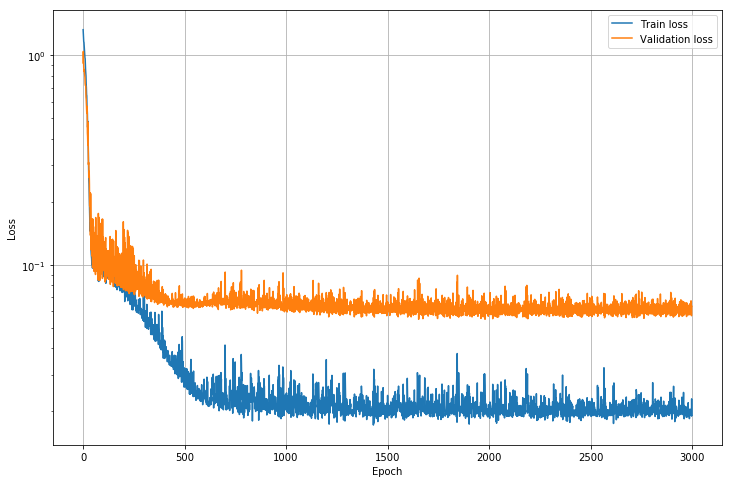

In [59]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

# Network analysis

In [60]:
# InputVector
x_vec = torch.linspace(0,1,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)
print(f'Input shape: {x_vec.shape}')

# Network output 
with torch.no_grad():
    y_vec = net(x_vec)
print(f'output shape: {y_vec.shape}')

# Expected output
beta_true = [-1.45, 1.12, 2.3]
true_model = poly_model(x_vec.cpu().numpy(), beta_true).squeeze()

Input shape: torch.Size([1000, 1])
output shape: torch.Size([1000, 1])


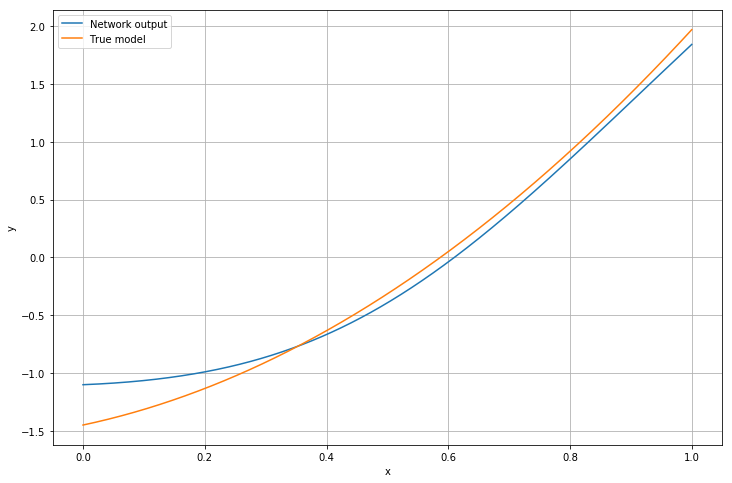

In [61]:
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.plot(x_vec, true_model, label='True model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

In [64]:
# Access network parameteres

# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

# Weights histogram

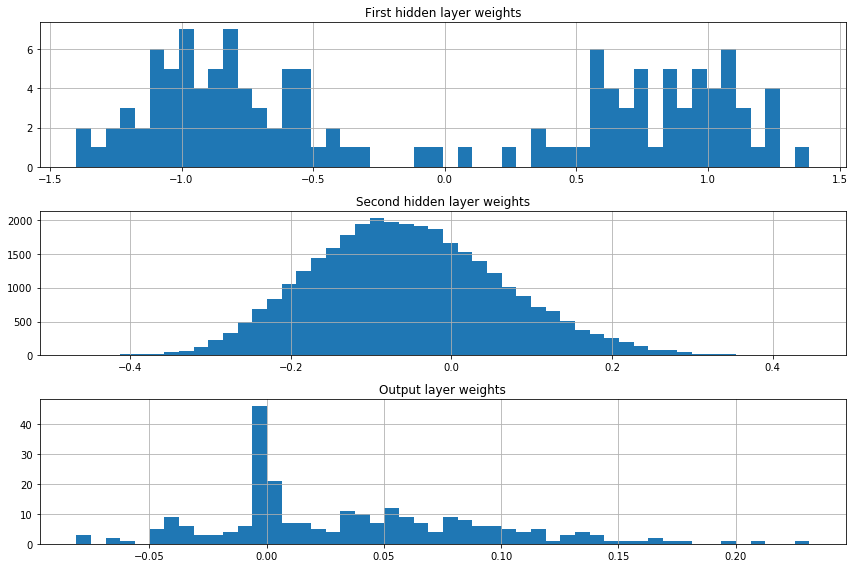

In [66]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

# Save network parameters

In [68]:
# Save network parameters
# Save the network state
# The state dictionary includes all the parameters of the network

net_state_dict = net.state_dict()

# Save the state dict to the file

torch.save(net_state_dict,'net_parameters.torch')

# Load network

In [71]:
# Reload the network state
# Fist initialize the network 

net = Net(Ni,Nh1,Nh2,No)

# Load the state dict previously saved
net_state_dict = torch.load('net_parameters.torch')

# Update the network parameteres
net.load_state_dict(net_state_dict)

Network initialized


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# Save optimizer state

You need to save both the network and the optimizer states if you want to continue your training

In [73]:
# Save the optimizer state

torch.save(optimizer.state_dict(), 'optimizer_state.torch')

# Reload the optimizer state
optimizer = optim.Adam(net.parameters(),lr = 0.001)
opt_state_dict = torch.load('optimizer_state.torch')
optimizer.load_state_dict(opt_state_dict)